In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

Your Name and PRN:
- Name: ______________________
- PRN : ______________________
- Date: ______________________

# Image Processing with Neural Network

## Assignment A06 : 
## Working with PyTorch
- Custom DataSet with common transformation
- Activation function of your choice
- Regularization:
    - L2, 
    - BatchNorm,
    - Dropout, 
    - Early Stopping.
    
- multi-class output
- Fashion MNIST dataset

In [4]:
###-----------------
### Import Libraries
###-----------------

import os
#import numpy as np
import pandas as pd
import sys
import numpy as np
from collections.abc import Callable
from typing import Literal


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
# import torch.nn.functional as F
# from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset, random_split
from torchsummary import summary
from torchvision import datasets
from torchvision.transforms import v2

parent_dir = os.path.abspath('..')
sys.path.insert(0, parent_dir)
from utils.helper import fn_plot_torch_hist, fn_plot_confusion_matrix

In [5]:
###-----------------
### Global Variables
###-----------------
inpDir = os.path.join('..', 'input')
outDir = '../output'
modelDir = os.path.join('..', 'model')
subDir = 'flower_photos'
altName = 'torch_flower'

BATCH_SIZE = 16
EPOCHS = 200
ALPHA = .001
TRAIN_SIZE = 2  * 92 * BATCH_SIZE
PATIENCE = 20
LR_FACTOR = .2
LR_PATIENCE = 5
RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
IMG_WIDTH = 200
IMG_HEIGHT = 200



FLIP_MODE = 'horizontal_and_vertical'
ROTATION_FACTOR = (-.1, .1)
FILL_MODE = 'nearest'


np.random.RandomState(RANDOM_STATE) # Set Random Seed for reproducible results
torch.manual_seed(RANDOM_STATE) ######

# parameters for Matplotlib
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 8),
          'axes.labelsize': 'large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'
         }

CMAP = 'brg' # plt.cm.Spectral

plt.rcParams.update(params)

## All about CUDA

In [7]:
import torchvision
torch.__version__, torchvision.__version__

('2.5.0', '0.20.0')

In [8]:
# print ('Is CUDA available: ', torch.cuda.is_available())

# print ('CUDA version: ', torch.version.cuda )

# print ('Current Device ID: ', torch.cuda.current_device())

# print ('Name of the CUDA device: ', torch.cuda.get_device_name(torch.cuda.current_device()))

In [9]:
# torch.cuda.get_device_name(torch.cuda.current_device()) # to se which gpu we are running

In [10]:
# Get cpu or gpu device for training.

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device} device")

Using cpu device


In [11]:
modelPath = os.path.join(modelDir, subDir, f'{altName}.pkl')

# custom datasets

In [13]:
'''define custom dataset'''
class AmnistDataset(Dataset):
    def __init__(self, X, y):
        super(AmnistDataset, self).__init__()
        self.X = torch.tensor(X, dtype = torch.float32)
        self.y = torch.tensor(y, dtype = torch.long)

    def __len__(self):
        return(len(self.X))

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


    
    

In [14]:
data_dir = os.path.join(inpDir, subDir)

In [15]:
# function to display images on the screen
def fn_imshow(image, ax = None, title = None, normalize = True):
    if ax is None:
        fig, ax = plt.subplots()

    image = image.numpy().transpose( (1, 2, 0) )
    if normalize:
        mean = np.array([0.485, .456, .406]) # harcoding these values because these are mentioned in torch documentation
        std = np.array([0.229, .224, .225])

        image = std * image + mean

        image = np.clip(image, 0, 1)

    ax.imshow(image)

    # improving its display

    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis = 'both', length = 0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    return ax

### transforms(images)



In [17]:
train_transform = v2.Compose([v2.Resize(IMG_HEIGHT),
                             v2.CenterCrop(IMG_HEIGHT),
                             v2.ToImage(),
                             v2.ToDtype(torch.float32, scale = True),
                             v2.Normalize(mean = np.array([0.485, .456, .406]),
        std = np.array([0.229, .224, .225]))
                             ]) # review this part from documentation


''' can add augmentation watch from documentation '''

test_transform = v2.Compose([v2.Resize(IMG_HEIGHT),
                             v2.CenterCrop(IMG_HEIGHT),
                             v2.ToImage(),
                             v2.ToDtype(torch.float32, scale = True),
                             v2.Normalize(mean = np.array([0.485, .456, .406]),
        std = np.array([0.229, .224, .225]))
                             ]) # review this part from documentation



### Load images

In [19]:
def create_dataset(data_dir, train_transform, test_transform):

    train_dataset = datasets.ImageFolder(data_dir, transform = train_transform) # read the images and transform them
    
    test_dataset = datasets.ImageFolder(data_dir, transform = test_transform) # read the images and transform them

    train_dataset_size = len(train_dataset)

    indices = torch.randperm(train_dataset_size).tolist() # random permutation

    dataset_train = torch.utils.data.Subset(train_dataset, indices[:TRAIN_SIZE])
    
    dataset_test = torch.utils.data.Subset(train_dataset, indices[TRAIN_SIZE:])

    return dataset_train, dataset_test

In [20]:
train_ds, test_ds = create_dataset(data_dir, train_transform, test_transform)
len(train_ds), len(test_ds)

(2944, 726)

In [21]:
class_name = {count: nclass for count, nclass in enumerate(train_ds.dataset.classes)}
class_name

{0: 'daisy', 1: 'dandelion', 2: 'roses', 3: 'sunflowers', 4: 'tulips'}

In [22]:
train_loader = DataLoader(train_ds, 
                                               batch_size = BATCH_SIZE,
                                               shuffle = True)

test_loader = DataLoader(test_ds, 
                                               batch_size = BATCH_SIZE,
                                               shuffle = True)

torch.Size([16, 3, 200, 200])

torch.Size([16])

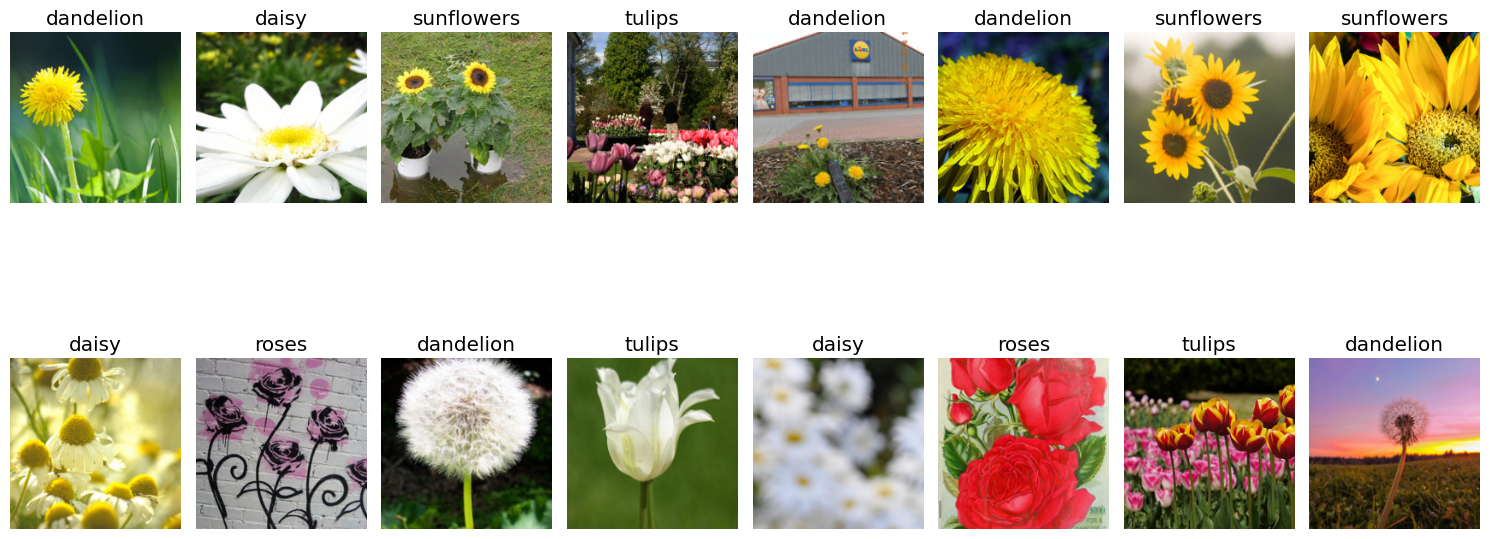

In [23]:
images, labels = next(iter(train_loader))
display(images.shape, labels.shape)# [16, 3, 188, 188] - batchsize, layer, height, width
fig = plt.figure()

for i in range(BATCH_SIZE):
    ax = fig.add_subplot(BATCH_SIZE//8, 8, (i+1) ,xticks = [], yticks = [])
    fn_imshow(images[i], ax = ax, normalize = True)
    ax.set_title(class_name[labels[i].item()])
plt.tight_layout()

torch.Size([16, 3, 200, 200])

torch.Size([16])

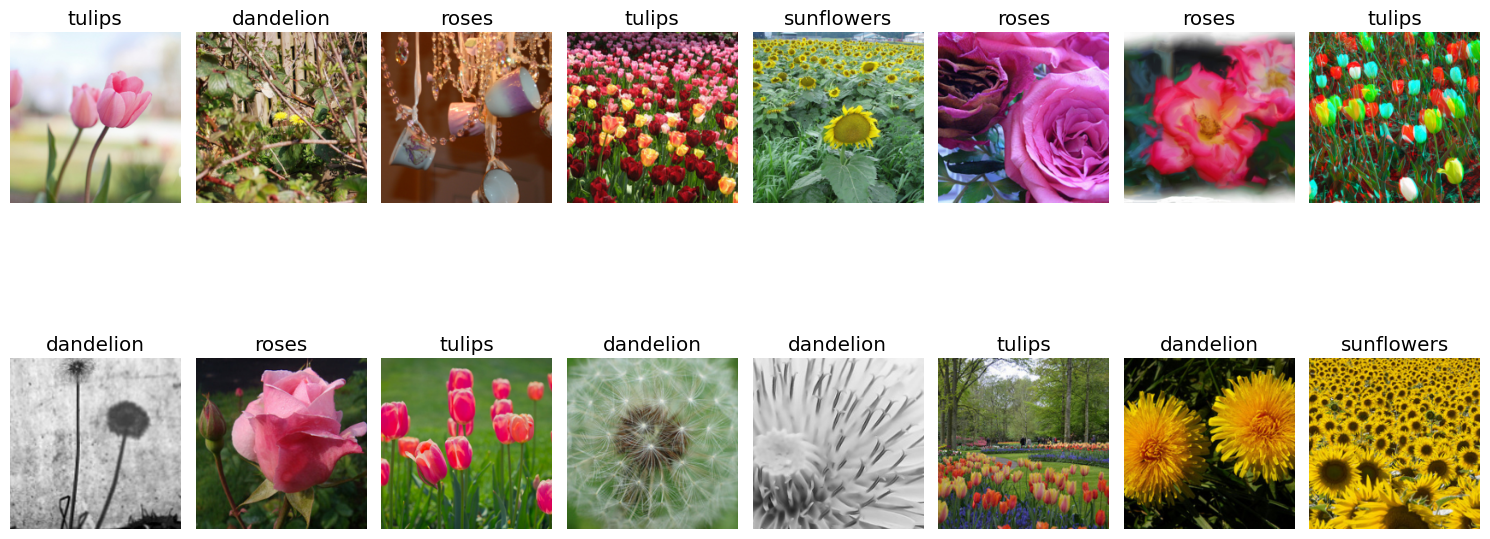

In [24]:
images, labels = next(iter(test_loader))
display(images.shape, labels.shape)# [16, 3, 188, 188] - batchsize, layer, height, width
fig = plt.figure()

for i in range(BATCH_SIZE):
    ax = fig.add_subplot(BATCH_SIZE//8, 8, (i+1) ,xticks = [], yticks = [])
    fn_imshow(images[i], ax = ax, normalize = True)
    ax.set_title(class_name[labels[i].item()])
plt.tight_layout()

In [25]:
class Model(nn.Module):
    ## drop out
    ## batch norm

    def __init__(self, numChannels, classes):
        super (Model, self).__init__()

        dor1 = .1

        # set 1
        self.conv1 = nn.Conv2d(in_channels = numChannels,
                              out_channels = 64,
                              kernel_size = (3, 3))  # 184 x 184 x 64
        self.actv1 = nn.LeakyReLU() # activation_function


        self.maxpool1 = nn.MaxPool2d(kernel_size = (4, 4),
                                    stride = (4,4)) # 46 x 46 x 64

        # set 2
        self.conv2 = nn.Conv2d(in_channels = 64,
                              out_channels = 128,
                              kernel_size = (3, 3))  # 44 x 44 x 128
        self.actv2 = nn.LeakyReLU() # activation_function


        self.maxpool2 = nn.MaxPool2d(kernel_size = (2, 2),
                                    stride = (2,2)) # 22 x 22 x 128

        # set 3
        self.conv3 = nn.Conv2d(in_channels = 128,
                              out_channels = 256,
                              kernel_size = (3, 3))  # 20 x 20 x 256
        self.actv3 = nn.LeakyReLU() # activation_function


        self.maxpool3 = nn.MaxPool2d(kernel_size = (2, 2),
                                    stride = (2,2)) # 10 x 10 x 256


        # set 4 
        self.conv4 = nn.Conv2d(in_channels = 256,
                              out_channels = 512,
                              kernel_size = (3, 3))  # 8 x 8 x 512
        self.actv4 = nn.LeakyReLU() # activation_function


        self.maxpool4 = nn.MaxPool2d(kernel_size = (2, 2),
                                    stride = (2,2)) # 4 x 4 x 512
        ###############
        ##### Head ####
        ###############
        self.fc1 = nn.Linear(in_features = 4 * 4 * 512, out_features = 1024)
        self.actv5 = nn.LeakyReLU()
        # here batchnorm will be 1d while in convolution layers it will be 2d

        self.fc2 = nn.Linear(in_features = 1024, out_features = classes)
        self.logSoftmax = nn.LogSoftmax(dim = 1)

        
    def forward(self, x): # forward propagation
        # set 1
        x = self.conv1(x)
        x = self.actv1(x)
        x = self.maxpool1(x)
        # set 2
        x = self.conv2(x)
        x = self.actv2(x)
        x = self.maxpool2(x)
        # set 3
        x = self.conv3(x)
        x = self.actv3(x)
        x = self.maxpool3(x)
        #set4
        x = self.conv4(x)
        x = self.actv4(x)
        x = self.maxpool4(x)
        # beteween head and the convolution layers we need to put the flatten layer
        # fully connected layer
        x = torch.flatten(x, 1)
        ### head ###
        x = self.fc1(x)
        x = self.actv5(x)
        x = self.fc2(x)
        x = self.logSoftmax(x)
        return x
model = Model(3, 5).to(device = device)
print(model)

Model(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (actv1): LeakyReLU(negative_slope=0.01)
  (maxpool1): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (actv2): LeakyReLU(negative_slope=0.01)
  (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (actv3): LeakyReLU(negative_slope=0.01)
  (maxpool3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (actv4): LeakyReLU(negative_slope=0.01)
  (maxpool4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=1024, bias=True)
  (actv5): LeakyReLU(negative_slope=0.01)
  (fc2): Linear(in_features=1024, out_features=5, bias=True)
  (logSoftmax)

In [26]:
_ = summary(model, input_size=(3, IMG_HEIGHT,IMG_WIDTH))
# summary(model, (1,input

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 198, 198]           1,792
         LeakyReLU-2         [-1, 64, 198, 198]               0
         MaxPool2d-3           [-1, 64, 49, 49]               0
            Conv2d-4          [-1, 128, 47, 47]          73,856
         LeakyReLU-5          [-1, 128, 47, 47]               0
         MaxPool2d-6          [-1, 128, 23, 23]               0
            Conv2d-7          [-1, 256, 21, 21]         295,168
         LeakyReLU-8          [-1, 256, 21, 21]               0
         MaxPool2d-9          [-1, 256, 10, 10]               0
           Conv2d-10            [-1, 512, 8, 8]       1,180,160
        LeakyReLU-11            [-1, 512, 8, 8]               0
        MaxPool2d-12            [-1, 512, 4, 4]               0
           Linear-13                 [-1, 1024]       8,389,632
        LeakyReLU-14                 [-

In [27]:
for param in list(model.parameters()):
    print(param.shape)

torch.Size([64, 3, 3, 3])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([256, 128, 3, 3])
torch.Size([256])
torch.Size([512, 256, 3, 3])
torch.Size([512])
torch.Size([1024, 8192])
torch.Size([1024])
torch.Size([5, 1024])
torch.Size([5])


In [28]:
# [196, 784] weight shape for layer 1
# similarly torch.Size([196]) : bias shape for layer 1 and so on 

In [29]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr = ALPHA)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', factor = LR_FACTOR,
                                                       patience = LR_PATIENCE,
                                                       min_lr = 1e-5) # the min_lr parameter specifies the minimum learning rate the optimizer is allowed to use. This acts as a lower bound for the learning rate during the training process.

chkptPath = os.path.join(modelDir, subDir, 'all_in_torch.keras')
# loss = []
loss, tloss, n_epoch, acc, tacc = [], [], [], [], []
patience = 0
miin = float('inf')

for epoch in range(EPOCHS):
    model.train()
    epoch_acc, epoch_loss = 0, 0
    for batch_idx, (train_X, train_y) in enumerate(train_loader):
        train_X, train_y = train_X.to(device), train_y.to(device)
        predict_proba = model(train_X)
        batch_loss = loss_fn(predict_proba, train_y)
        
        # Update running mean for loss
        epoch_loss += (batch_loss.item() - epoch_loss) / (batch_idx + 1)
        
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
        y_pred = predict_proba.argmax(dim=1)
        batch_acc = accuracy_score(train_y.cpu().numpy(), y_pred)
        epoch_acc += (batch_acc - epoch_acc) / (batch_idx + 1)
    
    loss.append(epoch_loss)
    acc.append(epoch_acc)
    
    model.eval()
    tepoch_loss, tepoch_acc = 0, 0
    with torch.no_grad():  # No gradients during validation
        for batch_idx, (test_X, test_y) in enumerate(test_loader):
            test_X, test_y = test_X.to(device), test_y.to(device)
            test_proba = model(test_X)
            batch_loss = loss_fn(test_proba, test_y)
            tepoch_loss += (batch_loss.item() - tepoch_loss) / (batch_idx + 1)
            
            y_pred = test_proba.argmax(dim=1).cpu().numpy()
            batch_acc = accuracy_score(test_y.cpu().numpy(), y_pred)
            tepoch_acc += (batch_acc - tepoch_acc) / (batch_idx + 1)
    
    tacc.append(tepoch_acc)
    tloss.append(tepoch_loss)
    n_epoch.append(epoch)
    
    # Scheduler step
    scheduler.step(tepoch_loss)
    
    # Early stopping
    if tepoch_loss < miin:
        print(f'Loss improved from {miin:.5f} to {tepoch_loss:.5f}')
        miin = tepoch_loss
        patience = 0 
        # torch.save(model.state_dict(), chkptPath)
        
    else:
        patience += 1
        print(f'Loss did not improve from {miin:.5f}. Current: {tepoch_loss:.5f}')
        if patience == PATIENCE:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break
    
    if epoch % 5 == 0 or tepoch_loss < miin:
        print("----------------------------------------------------------------------------------------------------------------------------------------------------")
        print(f'Epoch {epoch:>5d} | Loss: {epoch_loss:.5f}/{tepoch_loss:.5f} | ACC: {epoch_acc:.5f}/{tepoch_acc:.5f}')
        print(f'LR: {scheduler.get_last_lr()[0]:.5f}')
        print("----------------------------------------------------------------------------------------------------------------------------------------------------")


Loss improved from inf to 1.24700
----------------------------------------------------------------------------------------------------------------------------------------------------
Epoch     0 | Loss: 1.31617/1.24700 | ACC: 0.42052/0.45426
LR: 0.00100
----------------------------------------------------------------------------------------------------------------------------------------------------
Loss improved from 1.24700 to 1.08550
Loss improved from 1.08550 to 0.98551
Loss improved from 0.98551 to 0.89424
Loss did not improve from 0.89424. Current: 1.01642
Loss did not improve from 0.89424. Current: 1.00132
----------------------------------------------------------------------------------------------------------------------------------------------------
Epoch     5 | Loss: 0.68230/1.00132 | ACC: 0.73404/0.66350
LR: 0.00100
----------------------------------------------------------------------------------------------------------------------------------------------------
Loss did n

In [30]:
loss_df = pd.DataFrame({'epoch': n_epoch,
                        'loss': loss,
                        'test_loss' : tloss,
                        'acc' : acc,
                        'test_Acc': tacc})
loss_df.head()

,epoch,loss,test_loss,acc,test_Acc
0,0,1.316168,1.246995,0.420516,0.454257
1,1,1.106017,1.085497,0.528872,0.562953
2,2,0.940911,0.985515,0.628057,0.623641
3,3,0.879774,0.894242,0.654552,0.629076
4,4,0.768200,1.016417,0.694973,0.637681


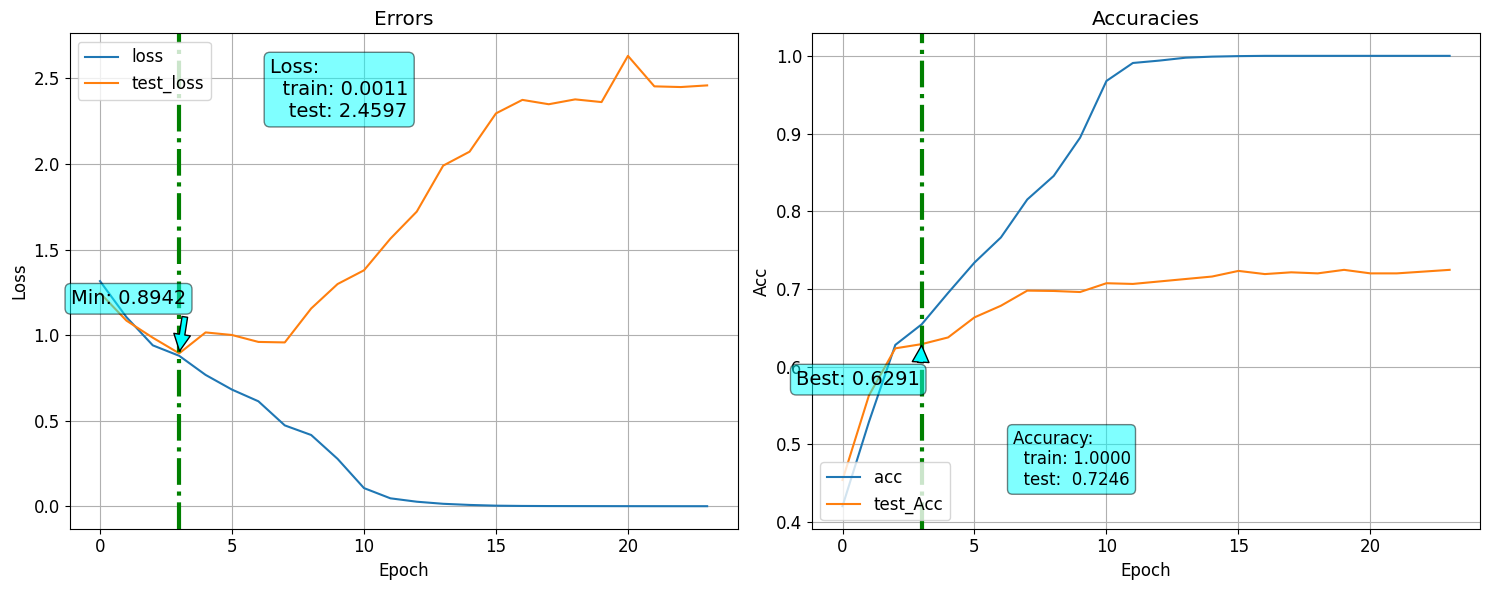

In [31]:
fn_plot_torch_hist(loss_df)